# Generation of data vectors with tomography with/without $k_{\rm cut}$.

In [1]:
import numpy as np
import pyccl
from astropy import constants as cst
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from scipy.special import gamma
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import fixed_quad
from scipy.integrate import quad
from scipy.integrate import romberg
from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.integrate import cumulative_trapezoid
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
import os

%pylab inline
pylab.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.autolayout': True})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


###  Set the pyccl cosmology

In [2]:
Omega_m = 0.31
sigma_8 = 0.81
h_100 = 0.6898
ns = 0.97
omega_b = 0.0223
A_IA = 0.0

In [3]:
Omega_b = omega_b/h_100/h_100
Omega_c = Omega_m - Omega_b

# define the cosmology object in ccl, used halofit as default
cosmo = pyccl.Cosmology(Omega_c = Omega_c, Omega_b = Omega_b,
                     sigma8 = sigma_8, n_s = ns, h = h_100)
cosmo

<pyccl.cosmology.Cosmology>
	Neff    = 3.044
	Omega_b = 0.04686606418624835
	Omega_c = 0.26313393581375166
	h       = 0.6898
	n_s     = 0.97
	sigma8  = 0.81
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0xfea96987a7408db8

In [4]:
astropy_cosmo = FlatLambdaCDM(H0=68.98, Om0=Omega_m,Ob0=0)

### Read all n(z) in one file and set up the n(z) tracers for pyccl

source redshift distributions:  /Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/source_LSST_10bins.dat
number of tomographic bins:  10
number of redshift entries:  300
0
1
2
3
4
5
6
7
8
9


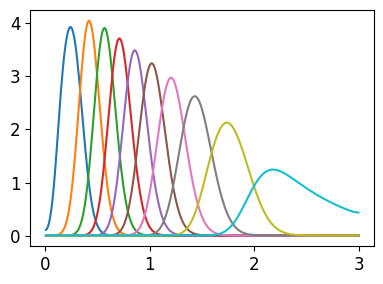

In [109]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

source_nz_path = '/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/source_lssty1.nz'
source_nz_path = '/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/source_LSST_10bins.dat'
#source_nz_path = 'axel_nz.txt'
file_data = np.loadtxt(source_nz_path)
nzrows = file_data.shape[0]
ntomobin = file_data.shape[1]-1
print("source redshift distributions: ",source_nz_path)
print("number of tomographic bins: ",ntomobin)
print("number of redshift entries: ",nzrows)

nz_table = np.zeros((nzrows,ntomobin+1))  # the i+1 is needed because the the first columns is "z"
nz_tracers = []

z_ccl = []
chi_ccl = []
w_ccl = []

A_IA = 0

for i in range(ntomobin):
    nz_table[:,0] = file_data[:,0]
    nz_table[:,i+1] = file_data[:,i+1]
    
    nz_tracers.append(pyccl.WeakLensingTracer(cosmo,dndz=(nz_table[:,0],nz_table[:,i+1]),
                                ia_bias=(nz_table[:,0],A_IA*np.ones_like(nz_table[:,0]))))
    
    chi_val,wchi_val = pyccl.get_lensing_kernel(cosmo,dndz=(nz_table[:,0],nz_table[:,i+1]))
    chi_ccl.append(chi_val)
    w_ccl.append(wchi_val)
    z_ccl.append(1/cosmo.scale_factor_of_chi(chi_ccl[i])-1)
    print(i)
    plt.plot(nz_table[:,0],nz_table[:,i+1])

<hr style="border-top: 3px solid #000;">

### Initialise $n_i^{(0)}$ and $n_i^{(1)}$ integrands for BNT transform

In [110]:
def n_0_i_int(z,n_of_z_interp):
    return n_of_z_interp(z)

def n_1_i_int(z,n_of_z_interp):
    chi_of_z = (astropy_cosmo.comoving_distance(z)/(cst.c/astropy_cosmo.H0)).cgs
    n_1_i_int = n_of_z_interp(z)/chi_of_z
    return n_1_i_int

##  Calculate lensing kernel $w_i(z)$ and $n_i^{(0)}$ and $n_i^{(1)}$ for each tomographic bin

###  What is being calculated:

$w_i(z)=\frac{3\Omega_0H_0}{2c} \int_{z' \ge z}{\rm d}z' ~n_{\rm i,interp}(z')\frac{[\chi(z')-\chi({\rm z})]\chi({\rm z})}{\chi(z')}(1+{\rm z})$

Note that the units are chosen to match the pyCCL convention

In [111]:
def kernel_int(zprime,zmin,n_of_z_interp):
    fact = 3./2.*Omega_m*(astropy_cosmo.H0/cst.c).to(1/u.Mpc)
    chi_of_zprime = (astropy_cosmo.comoving_distance(zprime)/(cst.c/astropy_cosmo.H0)).cgs
    chi_of_zmin = (astropy_cosmo.comoving_distance(zmin)/(cst.c/astropy_cosmo.H0)).cgs
    kernel_int = fact*(1+zmin)*n_of_z_interp(zprime)*(chi_of_zprime-chi_of_zmin)*chi_of_zmin/chi_of_zprime
    return kernel_int

0
1
2


/Users/waerbeke/miniconda3/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


3
4
5
6
7
8
9


,0,1,2,3,4,5,6,7,8,9
0,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.0000,1.000000
1,6.71868,2.772415,2.082481,1.715581,1.47209,1.29078,1.145154,1.019601,0.9022,0.772642


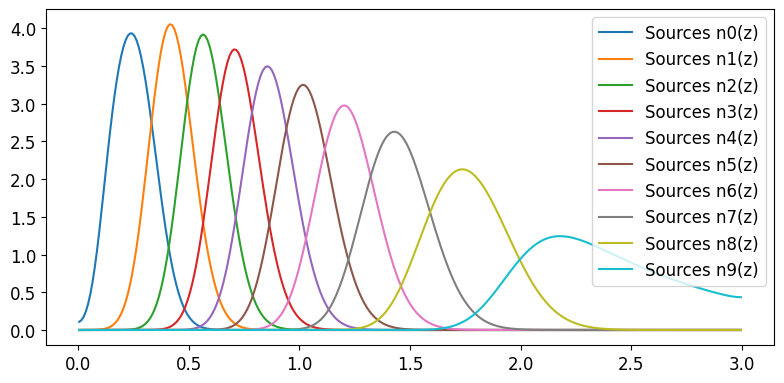

In [114]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

n_z_sample = 100  #  number of sampling points for n(z) plots
z_sample = np.linspace(0, 3., n_z_sample)
w_i_table = np.zeros((n_z_sample,ntomobin))

n_0 = np.zeros(ntomobin)
n_1 = np.zeros(ntomobin)

for i in range(ntomobin):
    print(i)
    z_list = nz_table[:,0]
    nz_list = nz_table[:,i+1]
    n_of_z_interp = interp1d(z_list,nz_list, kind='cubic',fill_value='extrapolate')
    
    for iz,(zpmin,) in enumerate(zip(z_sample)):
        z_values = np.linspace(zpmin,np.max(nz_table[:, 0]),5*n_z_sample)
        nz_values = kernel_int(z_values,zpmin,n_of_z_interp)
        nz_values[0] = 0.
        w_i_table[iz,i] = simpson(nz_values,z_values)

    zmin=1e-18
    zmax=3.#49945
    #n_of_z_interp = interp1d(nz_table[:,0], nz_table[:,i+1], kind='quadratic',fill_value='extrapolate')
    n_0[i], error = fixed_quad(n_0_i_int, zmin, zmax,args=(n_of_z_interp,),n=10000)
    n_1[i], error = fixed_quad(n_1_i_int, zmin, zmax, args=(n_of_z_interp,),n=10000)       
    
    plt.plot(nz_table[:,0],nz_table[:,i+1],label='Sources n'+str(i)+'(z)')
    #plt.plot(z_sample,1e5*w_i_table[:,i],label='Lensing kernel w'+str(i)+'(z)')
    plt.legend()

pd.DataFrame([n_0,n_1])

<hr style="border-top: 3px solid #000;">

## Initialize the kernel interpolation

In [115]:
w_kernel_interp = []
for i in range(ntomobin):
    print(i)
    w_kernel_interp.append(interp1d(z_sample,w_i_table[:,i], kind='cubic',fill_value='extrapolate'))

0
1
2
3
4
5
6
7
8
9


0
1
2
3
4
5
6
7
8
9


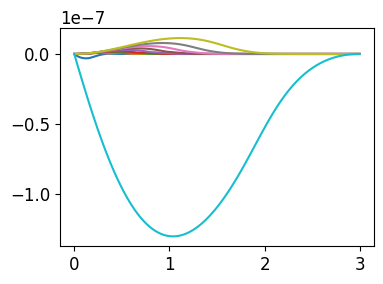

In [118]:
fig, axs = plt.subplots(1, 1, figsize=(4,3))

w_ccl_interp = []

for i in range(ntomobin):
    print(i)
    w_ccl_interp.append(interp1d(z_ccl[i], w_ccl[i], kind='quadratic',fill_value='extrapolate'))
    #w_ccl_interp.append(InterpolatedUnivariateSpline(z_ccl[i], w_ccl[i],k=4))
    plt.plot(z_sample,w_kernel_interp[i](z_sample)-w_ccl_interp[i](z_sample))
    #plt.plot(z_sample,w_ccl_interp(z_sample))

<hr style="border-top: 3px solid #000;">

# Calculate the BNT transform

In [119]:
p_a_i = np.zeros((ntomobin,ntomobin))
p_a_i[1,0] = -1
for i in range(ntomobin):
    p_a_i[i,i] = 1

In [120]:
for i in range(2,ntomobin):
    print(i)
    p_a_i[i,i-2] = (n_1[i]*n_0[i-1]-n_0[i]*n_1[i-1])/(n_0[i-2]*n_1[i-1]-n_1[i-2]*n_0[i-1])
    p_a_i[i,i-1] = (n_1[i]*n_0[i-2]-n_0[i]*n_1[i-2])/(n_0[i-1]*n_1[i-2]-n_1[i-1]*n_0[i-2])

2
3
4
5
6
7
8
9


## Calculate the $P_A^{~~I}$ matrix

### Calculate the $ (i,j) \rightarrow I$ index convertion to calculate $\left[ P_A^{~~I} ~{\rm block}\right]$

In [121]:
my_dict = {}
icpt = 0
for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        new_z_bin = {icpt:np.array((iz-1,jz-1))}
        my_dict.update(new_z_bin)
        #print(new_z_bin)
        icpt += 1

In [122]:
ntomoindex = int(ntomobin*(1+ntomobin)/2)
P_AI_block = np.zeros((ntomoindex,ntomoindex))

for A in range(1,ntomoindex+1):
    for I in range(1,ntomoindex+1):
        P_AI_block[A-1,I-1] = p_a_i[my_dict[A-1][1],my_dict[I-1][1]]*p_a_i[my_dict[A-1][0],my_dict[I-1][0]]
        if (my_dict[I-1][1] > my_dict[I-1][0]):
            P_AI_block[A-1,I-1] = P_AI_block[A-1,I-1] + p_a_i[my_dict[A-1][1],my_dict[I-1][0]]*p_a_i[my_dict[A-1][0],my_dict[I-1][1]]

/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


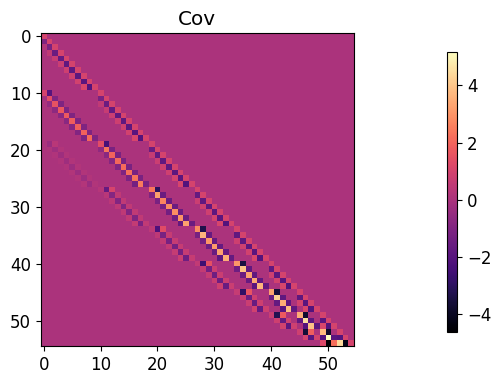

In [123]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))

im = axs.imshow(P_AI_block,cmap='magma')#,norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

### Calculate the full $P_A^{~~I}$ for the $\xi^{+/-}$ data vector from $\left[ P_A^{~~I} ~{\rm block}\right]$

In [124]:
n_theta = 20  #  number of theta scales
ntomoindex = int(ntomobin*(1+ntomobin)/2)
n_xi = n_theta*ntomoindex
n_P_AI = 2*n_theta*ntomoindex
P_AI = np.zeros((n_P_AI,n_P_AI))
ntomoindex,n_P_AI/2

(55, 1100.0)

In [125]:
for itheta in range(n_theta):
    i = itheta*ntomoindex
    P_AI[i:(i+ntomoindex),i:(i+ntomoindex)] = P_AI_block
    P_AI[n_xi+i:(n_xi+i+ntomoindex),n_xi+i:(n_xi+i+ntomoindex)] = P_AI_block

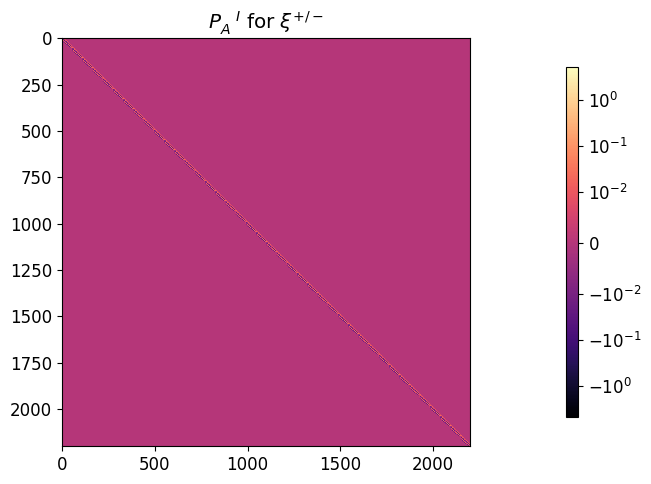

In [164]:
fig, axs = plt.subplots(1, 1, figsize=(6,5))

im = axs.imshow(P_AI,cmap='magma',norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("$P_A^{~~~I}$ for $\\xi^{+/-}$")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

### Calculate the full $P_A^{~~I}$ for the $C_\ell$ data vector from $\left[ P_A^{~~I} ~{\rm block}\right]$

In [157]:
n_ell = 10  #  number of ell modes
ntomoindex = int(ntomobin*(1+ntomobin)/2)
n_P_AI_4Cell = n_ell*ntomoindex
P_AI_4Cell = np.zeros((n_P_AI_4Cell,n_P_AI_4Cell))
ntomoindex,n_P_AI_4Cell

(55, 550)

In [165]:
for iell in range(n_ell):
    i = iell*ntomoindex
    P_AI_4Cell[i:(i+ntomoindex),i:(i+ntomoindex)] = P_AI_block

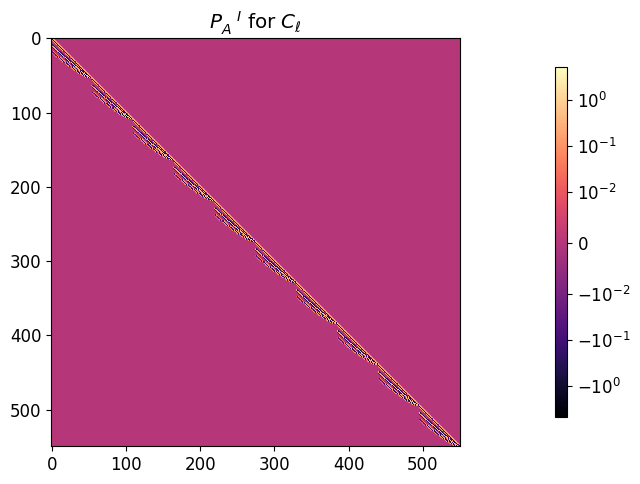

In [166]:
fig, axs = plt.subplots(1, 1, figsize=(6,5))

im = axs.imshow(P_AI_4Cell,cmap='magma',norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("$P_A^{~~~I}$ for $C_\ell$")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

<hr style="border-top: 3px solid #000;">

### Defining regular $(k,\chi)$ grid

In [127]:
k_array = np.logspace(-5,3,300)
#k_array = np.logspace(-3,-1,300)

chi_array = np.logspace(-2,3.8,300)

a_array = cosmo.scale_factor_of_chi(chi_array)
z_array = 1/a_array-1.

print('k_min: ',np.min(k_array),'k_max: ',np.max(k_array))
print('a_min: ',np.min(a_array),'a_max: ',np.max(a_array))
print('chi_min: ',np.min(chi_array),'chi_max: ',np.max(chi_array))
print('z_min: ',1/np.max(a_array)-1,'z_max: ',1/np.min(a_array)-1)

k_min:  1e-05 k_max:  1000.0
a_min:  0.2550075804587478 a_max:  0.9999976990831062
chi_min:  0.01 chi_max:  6309.57344480193
z_min:  2.300922188114285e-06 z_max:  2.9214520533116803


<hr style="border-top: 3px solid #000;">

### Calculation and Interpolation of the 3D power spectrum

In [128]:
p_of_k_a_NL = pyccl.power.nonlin_matter_power(cosmo,k_array,a_array)
log_of_P_NL = np.log10(p_of_k_a_NL)
log_of_P_NL_interp = RegularGridInterpolator((a_array,k_array),log_of_P_NL,method='cubic',bounds_error=False,fill_value=None)  #  the variables must be flipped

### Defining fonctions to calculate 2D $C_\ell$ with $k_{\rm cut}$
#### Note: this is for core calculation and not for data vector $C_\ell$ (which is done below)

#### $C_\ell$ integrand with $k_{\rm cut}$ hardcoded

In [151]:
def Cell_integrand(chi_values,ell_target,itomo,jtomo):
    a_values = cosmo.scale_factor_of_chi(chi_values)
    k_values = (ell_target+0.5)/chi_values
    ak_array = np.column_stack((a_values,k_values))
    
    k_cut = 1  #  This is the only location where you can change k_cut
    k_mask = np.exp(-(k_values/k_cut/np.sqrt(2))**2)

    z_values = 1/a_values-1
    kernel = w_ccl_interp[itomo](z_values)*w_ccl_interp[jtomo](z_values)/chi_values**2*10**log_of_P_NL_interp(ak_array)
    return kernel*k_mask

#### $C_\ell$ integral

In [130]:
def Cell_fct(ell_target,itomo,jtomo):

    for i,ell_value in enumerate(ell_target):
        if i == 0:
            Cell_vector = Cell_integrand(chi_array,ell_value,itomo,jtomo)
        if i > 0:
            Cell_vector = np.column_stack((Cell_integrand(chi_array,ell_value,itomo,jtomo), Cell_vector))

    Cell_vector = Cell_vector[:, ::-1]
    Cell_fct = simpson(Cell_vector,chi_array,axis=0)
    prefact = (ell_target+2)*(ell_target+1)*ell_target*(ell_target-1)/(ell_target+0.5)**4
    
    return prefact*Cell_fct

#### Dictionary counter - tomographic bin combinations

In [153]:
my_dict = {}
icpt = 0
for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        new_z_bin = {icpt:np.array((iz-1,jz-1))}
        my_dict.update(new_z_bin)
        #print(new_z_bin)
        icpt += 1

print('Number of tomographic bins: ',ntomobin)
print('Number of tomographic bins combinations: ',len(my_dict))

Number of tomographic bins:  10
Number of tomographic bins combinations:  55


#### Calculate CCL and custom $C_\ell$

In [132]:
ell_target = np.logspace(0.4,4.5,200)

Cell_pyccl = np.zeros((ntomobin,ntomobin,ell_target.size))
Cell_custom = np.zeros((ntomobin,ntomobin,ell_target.size))

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    print(icpt,iz,jz)
    Cell_pyccl[iz,jz,:] = pyccl.angular_cl(cosmo,nz_tracers[iz],nz_tracers[jz],ell_target)
    Cell_custom[iz,jz,:] = np.abs(Cell_fct(ell_target,iz,jz))

0 0 0
1 0 1
2 0 2
3 0 3
4 0 4
5 0 5
6 0 6
7 0 7
8 0 8
9 0 9
10 1 1
11 1 2
12 1 3
13 1 4
14 1 5
15 1 6
16 1 7
17 1 8
18 1 9
19 2 2
20 2 3
21 2 4
22 2 5
23 2 6
24 2 7
25 2 8
26 2 9
27 3 3
28 3 4
29 3 5
30 3 6
31 3 7
32 3 8
33 3 9
34 4 4
35 4 5
36 4 6
37 4 7
38 4 8
39 4 9
40 5 5
41 5 6
42 5 7
43 5 8
44 5 9
45 6 6
46 6 7
47 6 8
48 6 9
49 7 7
50 7 8
51 7 9
52 8 8
53 8 9
54 9 9


#### Plot CCL and custom $C_\ell$

Text(0.5, 1.0, '$\\Delta C_\\ell = C_\\ell(k<10) - C^{tot}_\\ell$')

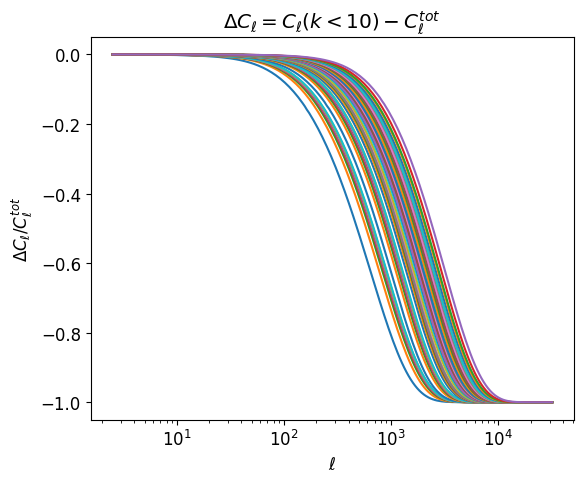

In [155]:
fig, axs = plt.subplots(1, 1, figsize=(6,5))

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    pycclCell = Cell_pyccl[iz,jz,:]
    customCell = Cell_custom[iz,jz,:]
    diff = (customCell-pycclCell)/pycclCell
    plt.plot(ell_target,diff,label=str(iz)+str(jz))

plt.xscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$\Delta C_\ell/C^{tot}_\ell$')
plt.title('$\Delta C_\ell = C_\ell(k<10) - C^{tot}_\ell$')
#plt.legend(fontsize=10)


<hr style="border-top: 3px solid #000;">

##  Calculate the $C_\ell$ data vectors

In [171]:
tomo_nbins = ntomobin*(ntomobin+1)
n_cell_entries = int(tomo_nbins*n_ell/2)
print('number of distinct tomographic bins combination: ',int(tomo_nbins/2))
print('number of data vector entries: ',str(int(tomo_nbins/2))+'x'+str(n_theta)+'=',n_cell_entries)

number of distinct tomographic bins combination:  55
number of data vector entries:  55x20= 550


In [173]:
Cell_I_CCL_order = np.zeros(n_cell_entries)
Cell_I_CCL_order_kcut = np.zeros(n_cell_entries)
Cell_I_BNT_order = np.zeros(n_cell_entries)
Cell_I_BNT_order_kcut = np.zeros(n_cell_entries)

In [179]:
ell_arr = np.logspace(1.5,3.5,n_ell)

Cell_ij_pyccl = np.zeros((ntomobin,ntomobin,n_ell))
Cell_ij_custom = np.zeros((ntomobin,ntomobin,n_ell))

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    #print(icpt,iz,jz)
    Cell_ij_pyccl[iz,jz,:] = pyccl.angular_cl(cosmo,nz_tracers[iz],nz_tracers[jz],ell_arr)
    Cell_ij_custom[iz,jz,:] = np.abs(Cell_fct(ell_arr,iz,jz))

Text(0.5, 1.0, 'pre-BNT')

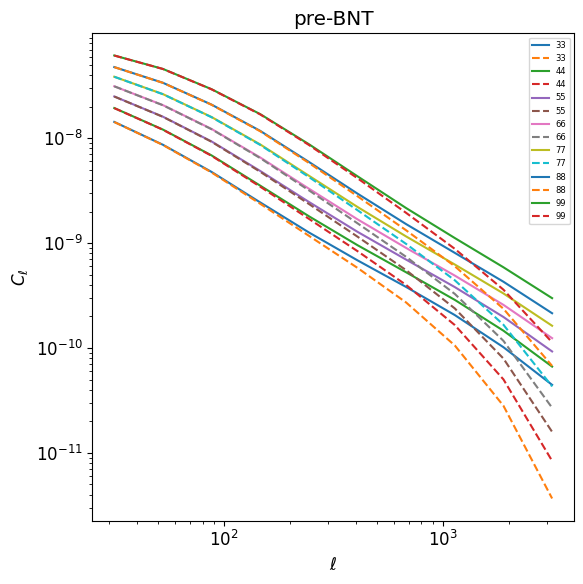

In [222]:
fig, axs = plt.subplots(1,1, figsize=(6,6))

icpt_vector = 0

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    Cell_I_CCL_order[icpt_vector:icpt_vector+n_ell] = Cell_ij_pyccl[iz,jz,:]
    Cell_I_CCL_order_kcut[icpt_vector:icpt_vector+n_ell] = Cell_ij_custom[iz,jz,:]
    if iz != 0 and iz != 1 and iz != 2  and jz < iz+1:
        #print(icpt,iz,jz)
        axs.semilogx(ell_arr,Cell_I_CCL_order[icpt_vector:icpt_vector+n_ell],label=str(iz)+str(jz))
        axs.semilogx(ell_arr,Cell_I_CCL_order_kcut[icpt_vector:icpt_vector+n_ell],label=str(iz)+str(jz),linestyle='--')
    icpt_vector += n_ell

plt.yscale('log')
plt.yscale('log')
plt.legend(fontsize=6)
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.title('pre-BNT')

#### Put the $C_\ell$ data vector in BNT order

In [194]:
icpt_vector = 0

for iell,ell_val in enumerate(ell_arr):
    for icpt in range(len(my_dict)):
        iz,jz = my_dict[icpt][0],my_dict[icpt][1]
        Cell_I_BNT_order[icpt_vector] = Cell_ij_pyccl[iz,jz,iell]
        Cell_I_BNT_order_kcut[icpt_vector] = Cell_ij_custom[iz,jz,iell]
        icpt_vector += 1

Text(0, 0.5, '$C_{\\ell,I}$')

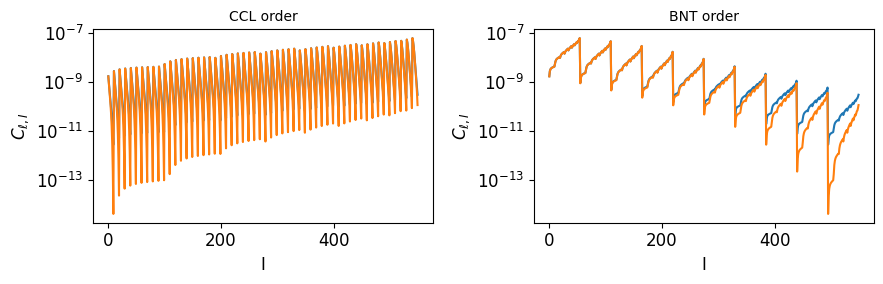

In [209]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(Cell_I_CCL_order)
axs[0].plot(Cell_I_CCL_order_kcut)
axs[0].set_title('CCL order',fontsize=10)
axs[0].set_xlabel('I')
#axs[0].set_xlim([1,200])
axs[0].set_yscale('log')
axs[0].set_ylabel('$C_{\ell,I}$')
axs[1].plot(Cell_I_BNT_order)
axs[1].plot(Cell_I_BNT_order_kcut)
axs[1].set_title('BNT order',fontsize=10)
axs[1].set_xlabel('I')
axs[1].set_yscale('log')
axs[1].set_ylabel('$C_{\ell,I}$')

#### Apply the BNT transform

In [210]:
Cell_A_BNT_order = P_AI_4Cell @ Cell_I_BNT_order
Cell_A_BNT_order_kcut = P_AI_4Cell @ Cell_I_BNT_order_kcut

#### Put BNT order $C_\ell$ data vectors back in CCL order (for post-BNT transform)

In [218]:
Cell_A_back2_CCL_order = np.zeros(n_cell_entries)
Cell_A_back2_CCL_order_kcut = np.zeros(n_cell_entries)

icpt_vector = 0

for icpt in range(len(my_dict)):
    for iell,ell_val in enumerate(ell_arr):
        Cell_A_back2_CCL_order[icpt_vector] = Cell_A_BNT_order[icpt+int(tomo_nbins/2)*iell]
        Cell_A_back2_CCL_order_kcut[icpt_vector] = Cell_A_BNT_order_kcut[icpt+int(tomo_nbins/2)*iell]
        icpt_vector += 1

Text(0, 0.5, '$C_{\\ell,I}$')

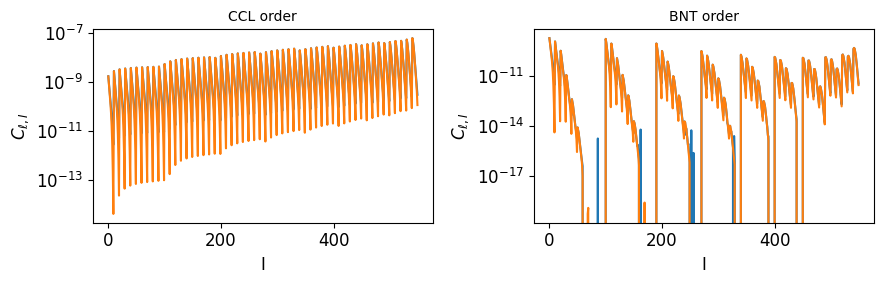

In [219]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(Cell_I_CCL_order)
axs[0].plot(Cell_I_CCL_order_kcut)
axs[0].set_title('CCL order',fontsize=10)
axs[0].set_xlabel('I')
#axs[0].set_xlim([1,200])
axs[0].set_yscale('log')
axs[0].set_ylabel('$C_{\ell,I}$')
axs[1].plot(Cell_A_back2_CCL_order)
axs[1].plot(Cell_A_back2_CCL_order_kcut)
axs[1].set_title('BNT order',fontsize=10)
axs[1].set_xlabel('I')
axs[1].set_yscale('log')
axs[1].set_ylabel('$C_{\ell,I}$')

Text(0.5, 1.0, 'post-BNT')

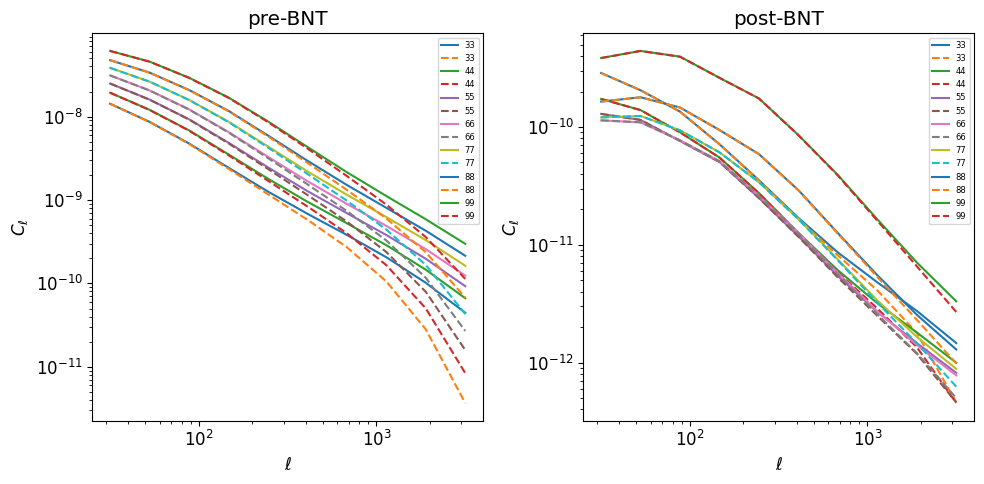

In [231]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

icpt_vector = 0

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    #Cell_I_CCL_order[icpt_vector:icpt_vector+n_ell] = Cell_ij_pyccl[iz,jz,:]
    #Cell_I_CCL_order_kcut[icpt_vector:icpt_vector+n_ell] = Cell_ij_custom[iz,jz,:]
    if iz != 0 and iz != 1 and iz != 2  and jz < iz+1:
        #print(icpt,iz,jz)
        axs[0].semilogx(ell_arr,Cell_I_CCL_order[icpt_vector:icpt_vector+n_ell],label=str(iz)+str(jz))
        axs[0].semilogx(ell_arr,Cell_I_CCL_order_kcut[icpt_vector:icpt_vector+n_ell],label=str(iz)+str(jz),linestyle='--')
        axs[1].semilogx(ell_arr,Cell_A_back2_CCL_order[icpt_vector:icpt_vector+n_ell],label=str(iz)+str(jz))
        axs[1].semilogx(ell_arr,Cell_A_back2_CCL_order_kcut[icpt_vector:icpt_vector+n_ell],label=str(iz)+str(jz),linestyle='--')
    icpt_vector += n_ell

axs[0].set_yscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize=6)
axs[0].set_xlabel('$\ell$')
axs[0].set_ylabel('$C_\ell$')
axs[0].set_title('pre-BNT')

axs[1].set_yscale('log')
axs[1].set_yscale('log')
axs[1].legend(fontsize=6)
axs[1].set_xlabel('$\ell$')
axs[1].set_ylabel('$C_\ell$')
axs[1].set_title('post-BNT')

##  Calculate the $\xi^{+/-}$ data vectors

In [167]:
tomo_nbins = ntomobin*(ntomobin+1)
n_entries = tomo_nbins*n_theta
n_blocks = str(int(tomo_nbins*(tomo_nbins+1)/2))
print('number of distinct tomographic bins combination: ',int(tomo_nbins/2))
print('number of data vector entries: ','2x'+str(int(tomo_nbins/2))+'x'+str(n_theta)+'=',n_entries)

number of distinct tomographic bins combination:  55
number of data vector entries:  2x55x20= 2200


In [135]:
V_I_CCL_order = np.zeros(n_entries)
V_I_CCL_order_kcut = np.zeros(n_entries)
V_I_BNT_order = np.zeros(n_entries)
V_I_BNT_order_kcut = np.zeros(n_entries)

In [136]:
#  angular scales
theta_min = 1
theta_max = 200
n_theta = 20

def get_theta_bins(theta_min,theta_max,n_theta):
    bin_edges = np.logspace(np.log10(theta_min), np.log10(theta_max), n_theta+1)
    theta_center_arcmin = 2./3 * (bin_edges[1:]**3. - bin_edges[:-1]**3.)/(bin_edges[1:]**2. - bin_edges[:-1]**2.)
    theta_center_deg = theta_center_arcmin/60.
    theta_center_rad = np.deg2rad(theta_center_deg)
    bin_edges_deg = bin_edges/60.
    bin_edges_rad = np.deg2rad(bin_edges_deg)
    return theta_center_deg,bin_edges_deg

theta_arr,edges_theta = get_theta_bins(theta_min,theta_max,n_theta)
theta_arcmin_arr = theta_arr*60.

In [137]:
theta_arr

array([0.0193053 , 0.02516101, 0.03279288, 0.04273966, 0.05570351,
       0.07259957, 0.09462057, 0.123321  , 0.16072689, 0.20947879,
       0.27301817, 0.3558304 , 0.46376135, 0.60443005, 0.78776657,
       1.02671297, 1.3381369 , 1.74402236, 2.27302152, 2.96247741])

27 3 3
34 4 4
40 5 5
45 6 6
49 7 7
52 8 8
54 9 9


Text(0.5, 1.0, 'pre-BNT')

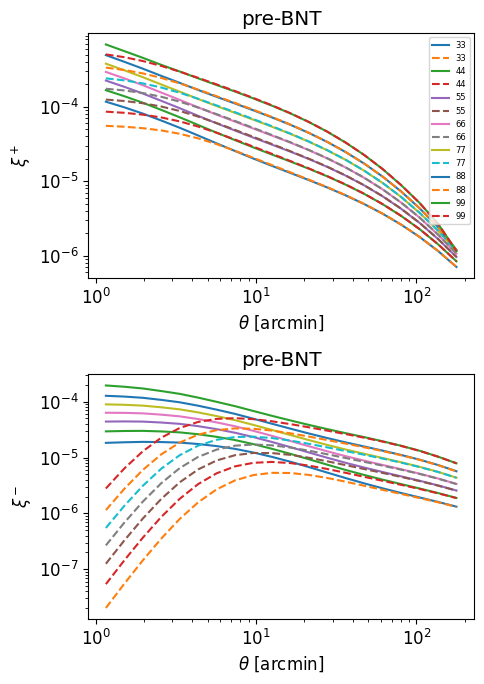

In [138]:
fig, axs = plt.subplots(2,1, figsize=(5,7))

icpt_vector = 0

xi_p = []
xi_p_kcut = []

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    xi_p.append(pyccl.correlation(cosmo,ell=ell_target,C_ell=Cell_pyccl[iz,jz,:],theta=theta_arr,type='GG+',method='Bessel'))
    xi_p_kcut.append(pyccl.correlation(cosmo,ell=ell_target,C_ell=Cell_custom[iz,jz,:],theta=theta_arr,type='GG+',method='Bessel'))
    V_I_CCL_order[icpt_vector:icpt_vector+n_theta] = xi_p[icpt]
    V_I_CCL_order_kcut[icpt_vector:icpt_vector+n_theta] = xi_p_kcut[icpt]
    if iz != 0 and iz != 1 and iz != 2  and jz < iz+1:
        print(icpt,iz,jz)
        axs[0].semilogx(theta_arcmin_arr,V_I_CCL_order[icpt_vector:icpt_vector+n_theta],label=str(iz)+str(jz))
        axs[0].semilogx(theta_arcmin_arr,V_I_CCL_order_kcut[icpt_vector:icpt_vector+n_theta],label=str(iz)+str(jz),linestyle='--')
    icpt_vector += n_theta

xi_m = []
xi_m_kcut = []

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    xi_m.append(pyccl.correlation(cosmo,ell=ell_target,C_ell=Cell_pyccl[iz,jz,:],theta=theta_arr,type='GG-',method='Bessel'))
    xi_m_kcut.append(pyccl.correlation(cosmo,ell=ell_target,C_ell=Cell_custom[iz,jz,:],theta=theta_arr,type='GG-',method='Bessel'))
    V_I_CCL_order[icpt_vector:icpt_vector+n_theta] = xi_m[icpt]
    V_I_CCL_order_kcut[icpt_vector:icpt_vector+n_theta] = xi_m_kcut[icpt]
    if iz != 0 and iz != 1 and iz != 2  and jz < iz+1:
        axs[1].semilogx(theta_arcmin_arr,V_I_CCL_order[icpt_vector:icpt_vector+n_theta],label=str(iz)+str(jz))
        axs[1].semilogx(theta_arcmin_arr,V_I_CCL_order_kcut[icpt_vector:icpt_vector+n_theta],label=str(iz)+str(jz),linestyle='--')
    icpt_vector += n_theta


axs[0].set_yscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize=6)
axs[0].set_xlabel('$\\theta$ [arcmin]')
axs[0].set_ylabel('$\\xi^+$')
axs[0].set_title('pre-BNT')
axs[1].set_yscale('log')
axs[1].set_yscale('log')
#axs[1].legend(fontsize=6)
axs[1].set_xlabel('$\\theta$ [arcmin]')
axs[1].set_ylabel('$\\xi^-$')
axs[1].set_title('pre-BNT')

#### Put CCL data vector in BNT order for full data vector

In [139]:
icpt_vector = 0

#for itheta,theta_val in enumerate(theta_arr):
#    for icpt in range(len(my_dict)):
#        V_I_BNT_order[icpt_vector] = xi_p[icpt][itheta]
#        V_I_BNT_order[icpt_vector+int(n_entries/2)] = xi_m[icpt][itheta]
#        icpt_vector += 1

for itheta,theta_val in enumerate(theta_arr):
    #print(itheta,theta_val)
    icpt = 0
    for iz in range(1,ntomobin+1):
        for jz in range(iz,ntomobin+1):
            V_I_BNT_order[icpt_vector] = xi_p[icpt][itheta]
            V_I_BNT_order[icpt_vector+int(n_entries/2)] = xi_m[icpt][itheta]
            icpt += 1
            icpt_vector += 1

#### Put CCL data vector in BNT order for k_cut data vector

In [140]:
icpt_vector = 0

for itheta,theta_val in enumerate(theta_arr):
    for icpt in range(len(my_dict)):
        V_I_BNT_order_kcut[icpt_vector] = xi_p_kcut[icpt][itheta]
        V_I_BNT_order_kcut[icpt_vector+int(n_entries/2)] = xi_m_kcut[icpt][itheta]
        icpt_vector += 1

Text(0, 0.5, '$V_I$')

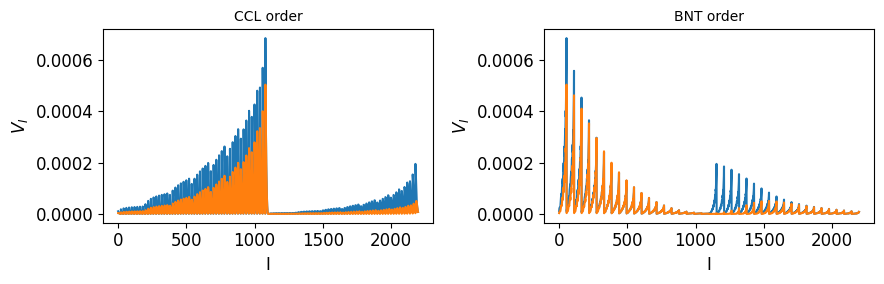

In [141]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(V_I_CCL_order)
axs[0].plot(V_I_CCL_order_kcut)

axs[0].set_title('CCL order',fontsize=10)
axs[0].set_xlabel('I')
#axs[0].set_xlim([200,600])
axs[0].set_ylabel('$V_I$')
axs[1].plot(V_I_BNT_order)
axs[1].plot(V_I_BNT_order_kcut)
axs[1].set_title('BNT order',fontsize=10)
axs[1].set_xlabel('I')
axs[1].set_ylabel('$V_I$')

#### Apply the BNT transform

In [142]:
V_A_BNT_order = P_AI @ V_I_BNT_order
V_A_BNT_order_kcut = P_AI @ V_I_BNT_order_kcut

#### Put BNT order data vectors back in CCL order (for pre-BNT transform)

In [143]:
V_I_back2_CCL_order = np.zeros(n_entries)
V_I_back2_CCL_order_kcut = np.zeros(n_entries)

icpt_vector = 0

for icpt in range(len(my_dict)):
    for itheta,theta_val in enumerate(theta_arr):
        V_I_back2_CCL_order[icpt_vector] = V_I_BNT_order[icpt+int(tomo_nbins/2)*itheta]
        V_I_back2_CCL_order[icpt_vector+int(n_entries/2)] = V_I_BNT_order[icpt+int(tomo_nbins/2)*itheta+int(n_entries/2)]
        V_I_back2_CCL_order_kcut[icpt_vector] = V_I_BNT_order_kcut[icpt+int(tomo_nbins/2)*itheta]
        V_I_back2_CCL_order_kcut[icpt_vector+int(n_entries/2)] = V_I_BNT_order_kcut[icpt+int(tomo_nbins/2)*itheta+int(n_entries/2)]
        icpt_vector += 1

#### Put BNT order data vectors back in CCL order (for post-BNT transform)

In [144]:
V_A_back2_CCL_order = np.zeros(n_entries)
V_A_back2_CCL_order_kcut = np.zeros(n_entries)

icpt_vector = 0

for icpt in range(len(my_dict)):
    for itheta,theta_val in enumerate(theta_arr):
        V_A_back2_CCL_order[icpt_vector] = V_A_BNT_order[icpt+int(tomo_nbins/2)*itheta]
        V_A_back2_CCL_order[icpt_vector+int(n_entries/2)] = V_A_BNT_order[icpt+int(tomo_nbins/2)*itheta+int(n_entries/2)]
        V_A_back2_CCL_order_kcut[icpt_vector] = V_A_BNT_order_kcut[icpt+int(tomo_nbins/2)*itheta]
        V_A_back2_CCL_order_kcut[icpt_vector+int(n_entries/2)] = V_A_BNT_order_kcut[icpt+int(tomo_nbins/2)*itheta+int(n_entries/2)]
        icpt_vector += 1

Text(0, 0.5, '$V_I$')

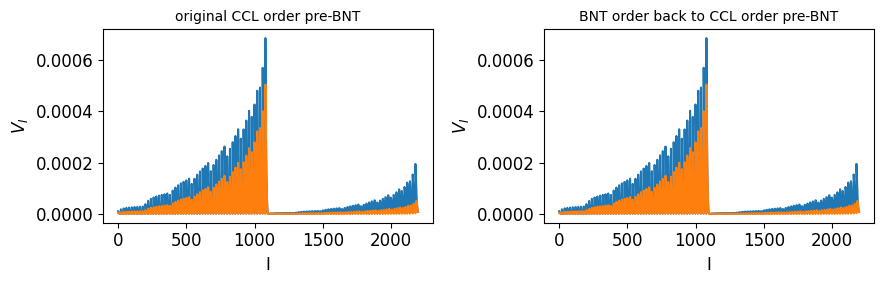

In [145]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(V_I_CCL_order)
axs[0].plot(V_I_CCL_order_kcut)
axs[0].set_title('original CCL order pre-BNT',fontsize=10)
#axs[0].set_xlim([0,100])

axs[0].set_xlabel('I')
axs[0].set_ylabel('$V_I$')
axs[1].plot(V_I_back2_CCL_order)
axs[1].plot(V_I_back2_CCL_order_kcut)
axs[1].set_title('BNT order back to CCL order pre-BNT',fontsize=10)
#axs[1].set_xlim([0,100])

axs[1].set_xlabel('I')
axs[1].set_ylabel('$V_I$')

Text(0, 0.5, '$V_I$')

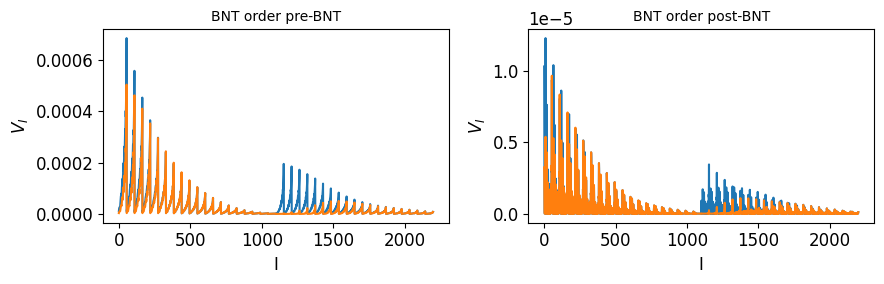

In [146]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(V_I_BNT_order)
axs[0].plot(V_I_BNT_order_kcut)
axs[0].set_title('BNT order pre-BNT',fontsize=10)
#axs[0].set_xlim([0,100])

axs[0].set_xlabel('I')
axs[0].set_ylabel('$V_I$')
axs[1].plot(V_A_BNT_order)
axs[1].plot(V_A_BNT_order_kcut)
axs[1].set_title('BNT order post-BNT',fontsize=10)
#axs[1].set_xlim([0,100])

axs[1].set_xlabel('I')
axs[1].set_ylabel('$V_I$')

Text(0, 0.5, '$V_I$')

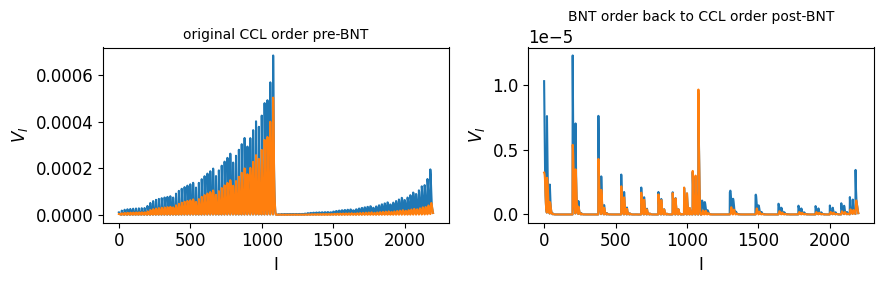

In [147]:
fig, axs = plt.subplots(1,2, figsize=(9,3))

axs[0].plot(V_I_CCL_order)
axs[0].plot(V_I_CCL_order_kcut)
axs[0].set_title('original CCL order pre-BNT',fontsize=10)
#axs[0].set_xlim([0,90])
#axs[0].set_ylim([0,3e-5])

axs[0].set_xlabel('I')
axs[0].set_ylabel('$V_I$')

axs[1].plot(V_A_back2_CCL_order)
axs[1].plot(V_A_back2_CCL_order_kcut)
axs[1].set_title('BNT order back to CCL order post-BNT',fontsize=10)
#axs[1].set_xlim([0,90])
#axs[1].set_ylim([0,3e-5])


axs[1].set_xlabel('I')
axs[1].set_ylabel('$V_I$')

Text(0.5, 1.0, 'post-BNT')

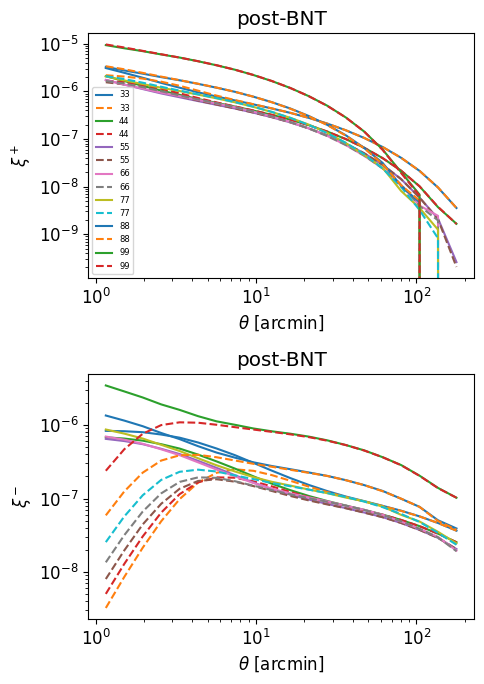

In [149]:
fig, axs = plt.subplots(2,1, figsize=(5,7))

icpt_vector = 0

xi_p = []
xi_p_kcut = []

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    #print(icpt,iz,jz)
    if iz != 0 and iz != 1 and iz != 2 and jz < iz+1:
        axs[0].semilogx(theta_arcmin_arr,V_A_back2_CCL_order[icpt_vector:icpt_vector+n_theta],label=str(iz)+str(jz))
        axs[0].semilogx(theta_arcmin_arr,V_A_back2_CCL_order_kcut[icpt_vector:icpt_vector+n_theta],label=str(iz)+str(jz),linestyle='--')
    icpt_vector += n_theta

xi_m = []
xi_m_kcut = []

for icpt in range(len(my_dict)):
    iz,jz = my_dict[icpt][0],my_dict[icpt][1]
    if iz != 0 and iz != 1 and iz != 2  and jz < iz+1:
        axs[1].semilogx(theta_arcmin_arr,V_A_back2_CCL_order[icpt_vector:icpt_vector+n_theta],label=str(iz)+str(jz))
        axs[1].semilogx(theta_arcmin_arr,V_A_back2_CCL_order_kcut[icpt_vector:icpt_vector+n_theta],label=str(iz)+str(jz),linestyle='--')
    icpt_vector += n_theta



axs[0].set_yscale('log')
axs[0].set_yscale('log')
axs[0].legend(fontsize=6)
axs[0].set_xlabel('$\\theta$ [arcmin]')
axs[0].set_ylabel('$\\xi^+$')
axs[0].set_title('post-BNT')
axs[1].set_yscale('log')
axs[1].set_yscale('log')
#axs[1].legend(fontsize=6)
axs[1].set_xlabel('$\\theta$ [arcmin]')
axs[1].set_ylabel('$\\xi^-$')
axs[1].set_title('post-BNT')